In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
import pickle

np.set_printoptions(suppress = True)

plt.rcParams['figure.figsize'] = 8,5

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')


In [3]:
df = train_df

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **Basic EDA and Visualizations**

In [5]:
df.shape

(891, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


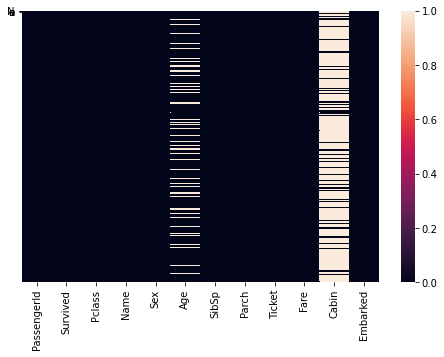

In [8]:
#Check for null values
sns.heatmap(df.isnull(),yticklabels='None')
plt.show()

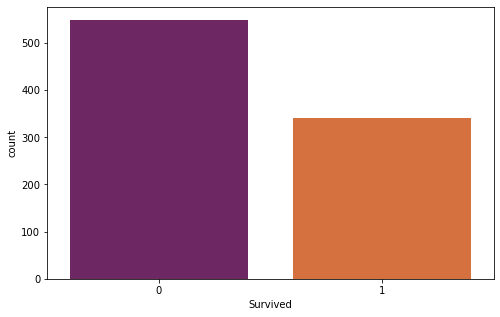

In [9]:
#Check how many travellers survived and how many didn't
sns.countplot('Survived',data = df,palette='inferno')
plt.show()





Imbalanced dataset. Positive class is lower than the negative

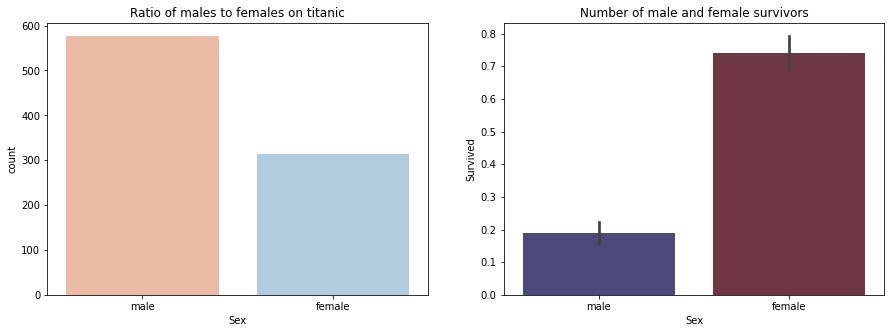

In [10]:
#Analysis of Sex and Survived
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
sns.countplot('Sex',data=df,ax=ax1,palette='RdBu')
ax1.set_title("Ratio of males to females on titanic")
ax2 = fig.add_subplot(1,2,2)
sns.barplot('Sex','Survived',data = df,ax=ax2,palette='icefire')

ax2.set_title("Number of male and female survivors")

plt.show()

More males in the dataset but more number of female survivors. Let's see the male and female survival rate

In [11]:
#Calculating the male and female survival rate
total_male = (train_df['Sex']=='male').sum()
total_male_survived = ((train_df['Sex']=='male')&(train_df['Survived']==1)).sum()

total_female = (train_df['Sex']=='female').sum()
total_female_survived = ((train_df['Sex']=='female')&(train_df['Survived']==1)).sum()

print("Male survival rate : {:.2f}%".format(total_male_survived*100/total_male))
print("Female survival rate : {:.2f}%".format(total_female_survived*100/total_female))

Male survival rate : 18.89%
Female survival rate : 74.20%


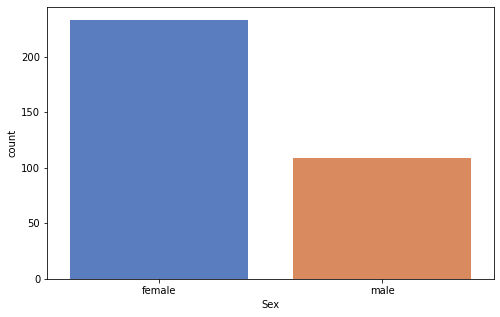

In [12]:
#Amongst the people that survived, how many male and female
survived = train_df[train_df['Survived']==1][['Survived','Sex']]

sns.countplot('Sex',data=survived,palette='muted')
plt.show()

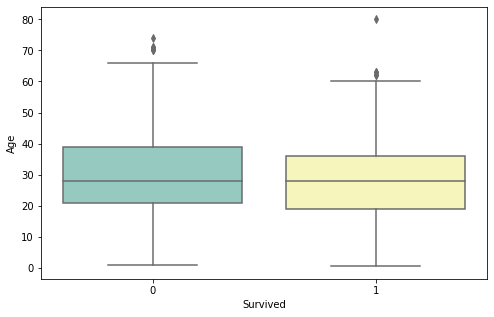

In [13]:
#Age of the people that survived and that didn't
sns.boxplot('Survived','Age',data=df,palette='Set3')
plt.show()

Most of the people between the ages of 20 and 40

In [14]:
#Analyzing the distribution of fare amongst survivors and non survivors
survived_fare = train_df[train_df['Survived']==1]['Fare']
notsurvived_fare = train_df[train_df['Survived']==0]['Fare']

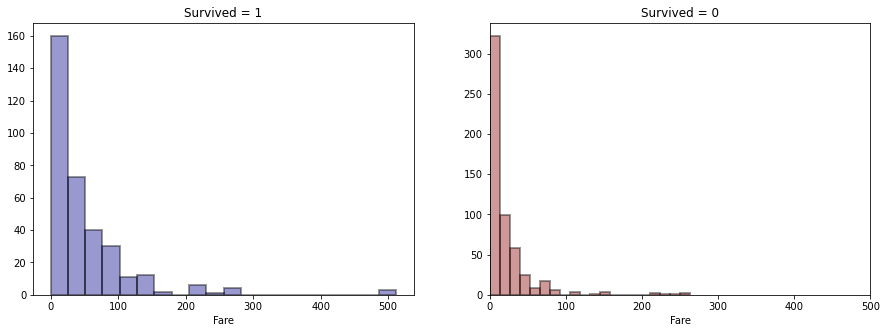

In [15]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
sns.distplot(survived_fare,kde=False,hist_kws=dict(edgecolor="k", linewidth=2),bins =20,ax=ax1,color='darkblue')
ax1.set_title("Survived = 1")
ax2 = fig.add_subplot(1,2,2)
sns.distplot(notsurvived_fare,kde=False,hist_kws=dict(edgecolor="k", linewidth=2),bins =20,ax=ax2,color='darkred')
ax2.set_title("Survived = 0")
ax2.set_xlim(0,500)
plt.show()

People who paid higher fare have survived than the ones who paid lower fare or you could say richer people survived.

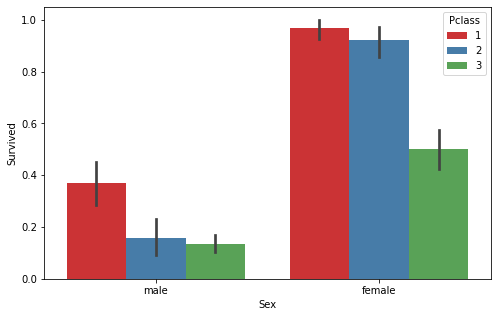

In [16]:
#Analyzing Pclass
sns.barplot('Sex','Survived',hue='Pclass',data=train_df,palette='Set1')
plt.show()

As expected, 1st class travellers have survived more than second/third class survivors

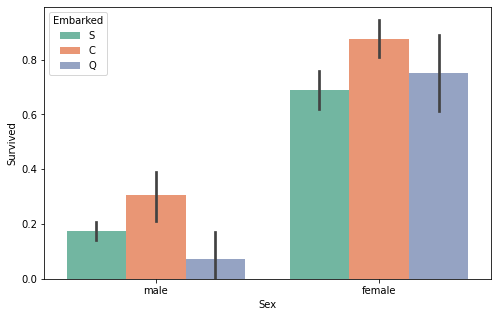

In [17]:
#Where did the survivors embark
sns.barplot('Sex','Survived',hue='Embarked',data=train_df,palette='Set2')
plt.show()

People who embarked on Cherbourg have higher survival percentage

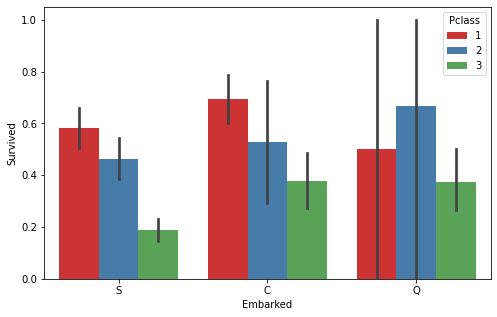

In [18]:
sns.barplot('Embarked','Survived',hue = 'Pclass',data = train_df,palette='Set1')

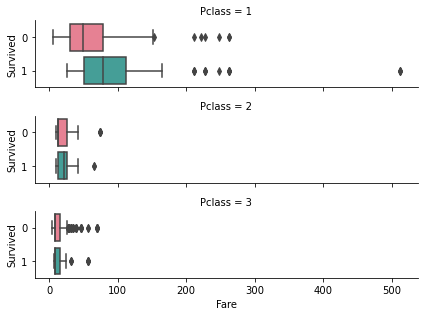

In [19]:
sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train_df.query("Fare > 0"),palette='husl')
plt.show()

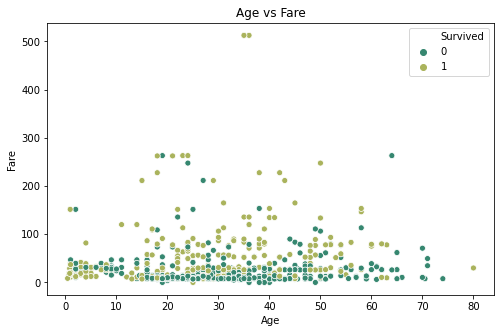

In [20]:
sns.scatterplot('Age','Fare',hue = 'Survived',data=train_df,palette = 'gist_earth')
plt.title("Age vs Fare")
plt.show()

A few outliers in Fare. These could be influential for the problem. May consider removing those while building the models

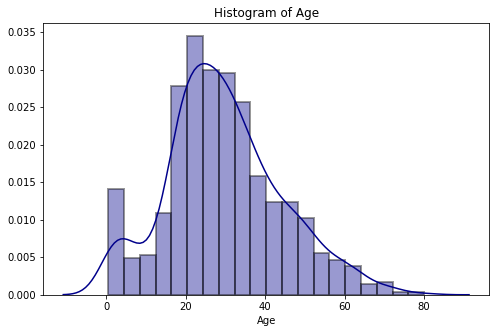

In [21]:
sns.distplot(train_df[train_df['Age'].notnull()]['Age'],bins=20,kde=True,hist_kws=dict(edgecolor="k", linewidth=2),color='DarkBlue')
plt.title("Histogram of Age")
plt.show()

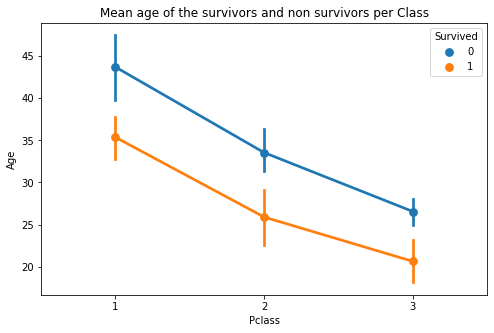

In [22]:
sns.pointplot('Pclass','Age',hue = 'Survived',data = train_df)
plt.title("Mean age of the survivors and non survivors per Class")
plt.show()

### **Creating new features**


In [23]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [24]:
#Create family size as a linear combination of sibling, spouse, parents and children
df['family_size'] = df['SibSp']+df['Parch']


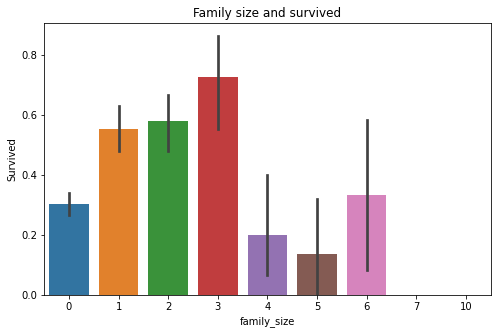

In [25]:
#Relationship of family size and survived
sns.barplot('family_size','Survived',data = train_df)
plt.title("Family size and survived")
plt.show()

Family size of 3 have had a higher survival rate than family sizes of zero. Family size of 5 had the lowest survival percentage. Family sizes of over 6 have not survived.

In [26]:
#Create title feature
def find_substrings(main_string,substrings):
  for substring in substrings:
    if (main_string.find(substring))!=-1:
      return substring
  return np.nan


In [27]:
titles_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [28]:
df['title'] = df['Name'].apply(lambda x: find_substrings(x,titles_list))

In [29]:
def replace_title(x):
  title = x['title']
  if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
      return 'Mr'
  elif title in ['Countess', 'Mme']:
      return 'Mrs'
  elif title in ['Mlle', 'Ms']:
      return 'Miss'
  elif title =='Dr':
      if x['Sex']=='Male':
          return 'Mr'
      else:
          return 'Mrs'
  else:
      return title

In [30]:
df['title'] = df.apply(replace_title,axis = 1)

# Dropping rows with extreme outliers in 'Fare' column. After doing this, noticed an increase in cross validation scores but the test case scores for the three selected models have decreased 

In [31]:
# indices = df['Fare'][df['Fare']>400].index
# df.drop(indices,inplace = True)

In [32]:
#Drop 'Name','PassengerId', 'Ticket'
df.drop(columns = ['Name','PassengerId','Ticket','Cabin'],inplace = True)

In [33]:
#Encoding 'Sex' column
sex_dict = {'male':0,'female':1}
df['Sex'] = df['Sex'].map(sex_dict)

In [34]:
#Encoding 'Embark' column
embark_dict = {'C':0,'Q':1,'S':2}
df['Embarked'] = df['Embarked'].map(embark_dict)

In [35]:
#Encoding title column
title_dict = {"Mr":0,"Mrs":1,"Miss":2,"Master":3}
df['title'] = df['title'].map(title_dict)

In [36]:
#Remove Siblings, spouses, parent and children columns
#train_df.drop(columns = ['SibSp','Parch'],inplace = True)

In [37]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title
0,0,3,0,22.0,1,0,7.2500,2.0,1,0
1,1,1,1,38.0,1,0,71.2833,0.0,1,1
2,1,3,1,26.0,0,0,7.9250,2.0,0,2
3,1,1,1,35.0,1,0,53.1000,2.0,1,1
4,0,3,0,35.0,0,0,8.0500,2.0,0,0


# Age fill na with mean age based on the title

In [38]:
mean_age_0 = df['Age'][df['title']==0].mean()
mean_age_1 = df['Age'][df['title']==1].mean()
mean_age_2 = df['Age'][df['title']==2].mean()
mean_age_3 = df['Age'][df['title']==3].mean()

In [39]:
df.loc[df['title']==0,'Age'] = df.loc[df['title']==0,'Age'].fillna(mean_age_0)
df.loc[df['title']==1,'Age'] = df.loc[df['title']==1,'Age'].fillna(mean_age_1)
df.loc[df['title']==2,'Age'] = df.loc[df['title']==2,'Age'].fillna(mean_age_2)
df.loc[df['title']==3,'Age'] = df.loc[df['title']==3,'Age'].fillna(mean_age_3)

In [40]:

df[df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title
61,1,1,1,38.0,0,0,80.0,NaN,0,2
829,1,1,1,62.0,0,0,80.0,NaN,0,1


In [41]:
df.isna().sum()

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
family_size    0
title          0
dtype: int64

In [42]:

#instantiate both packages to use

encoder = OrdinalEncoder()
imputer = KNN()
# create a list of categorical columns to iterate over
cat_cols = ['Embarked','Pclass','Sex','Survived','title']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode data
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(df[columns])

/Users/poojadeshpande91/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/poojadeshpande91/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/poojadeshpande91/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [43]:
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df)),columns = df.columns)

Imputing row 1/891 with 0 missing, elapsed time: 0.156
Imputing row 101/891 with 0 missing, elapsed time: 0.157
Imputing row 201/891 with 0 missing, elapsed time: 0.158
Imputing row 301/891 with 0 missing, elapsed time: 0.158
Imputing row 401/891 with 0 missing, elapsed time: 0.159
Imputing row 501/891 with 0 missing, elapsed time: 0.159
Imputing row 601/891 with 0 missing, elapsed time: 0.160
Imputing row 701/891 with 0 missing, elapsed time: 0.161
Imputing row 801/891 with 0 missing, elapsed time: 0.161


In [44]:
for col_name in cat_cols:  
    # Perform inverse transform of the ordinally encoded columns
    encode_data[col_name] = encoder.inverse_transform(encode_data[col_name].values.reshape(-1,1))

In [45]:
encode_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title
0,0,2,0,22.0,1.0,0.0,7.0,2,1.0,0
1,1,0,1,38.0,1.0,0.0,71.0,0,1.0,1
2,1,2,1,26.0,0.0,0.0,8.0,2,0.0,2
3,1,0,1,35.0,1.0,0.0,53.0,2,1.0,1
4,0,2,0,35.0,0.0,0.0,8.0,2,0.0,0


In [46]:
X = encode_data.iloc[:,1:].values
y = encode_data.iloc[:,0].values

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)


# K nearest neighbors

In [48]:
knn = KNeighborsClassifier()

In [49]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [50]:
scores = cross_validate(knn,X_train,y_train,scoring=['accuracy','f1','roc_auc'])

In [51]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.72
Mean f1 with cross validation : 0.62
Mean ROC AUC score with cross validation : 0.76


# Decision Tree

In [52]:

dtree = DecisionTreeClassifier()

In [53]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [54]:
scores = cross_validate(dtree,X_train,y_train,scoring=['accuracy','f1','roc_auc'])

In [55]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.76
Mean f1 with cross validation : 0.69
Mean ROC AUC score with cross validation : 0.75


# Support Vector Machine

In [56]:
svm = SVC()

In [57]:
svm.fit(X_train,y_train)

SVC()

In [58]:
scores = cross_validate(svm,X_train,y_train,scoring=['accuracy','f1','roc_auc'])

In [59]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.67
Mean f1 with cross validation : 0.39
Mean ROC AUC score with cross validation : 0.75


# Based on cross validation scores, the following models were selected

# Logistic Regression Model

In [60]:
lr = LogisticRegression(max_iter = 1000)

In [61]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [62]:
scores = cross_validate(lr,X_train,y_train,scoring=['accuracy','f1','roc_auc'])


In [63]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.81
Mean f1 with cross validation : 0.74
Mean ROC AUC score with cross validation : 0.86


In [64]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}

grid = GridSearchCV(lr,param_grid,refit=True,verbose=2,scoring = "accuracy")
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


In [65]:
lr = LogisticRegression(max_iter = 1000,C = 0.1)

In [66]:
lr.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [67]:
#Predict on training and test data

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

In [68]:
#Evaluation

print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(y_train,pred_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(y_test,pred_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(y_test,pred_test))
print("\n=====Classification report=====\n")
print(classification_report(y_test,pred_test))

=====Accuracy score============

Train accuracy score : 0.8234
Test accuracy score : 0.8386

=====Confusion Matrix==========
 
[[128  11]
 [ 25  59]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       139
           1       0.84      0.70      0.77        84

    accuracy                           0.84       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.84      0.84      0.84       223



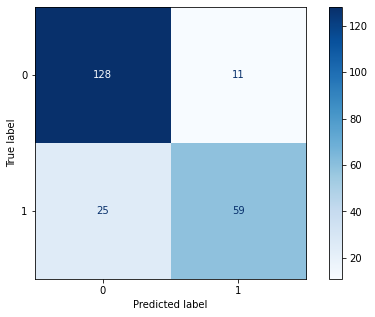

In [69]:
plot_confusion_matrix(lr,X_test,y_test,values_format='d',cmap = 'Blues')
plt.show()

In [70]:
probs = lr.predict_proba(X_test)[:,1]

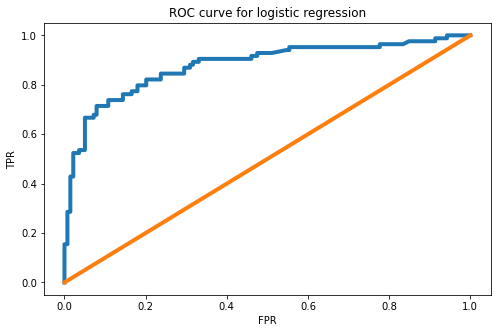

In [71]:
fpr,tpr,thresholds = roc_curve(y_test,probs)

plt.plot(fpr,tpr,linewidth = 4)
plt.plot([0,1],[0,1],linewidth = 4)
plt.title("ROC curve for logistic regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [72]:
score = roc_auc_score(y_test,probs)
print("ROC AUC score : {}".format(round(score,4)))

ROC AUC score : 0.8777


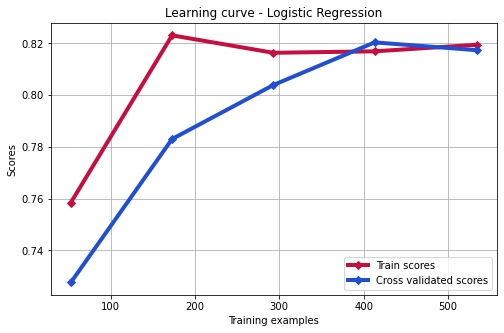

In [73]:
#Learning curve
lc = learning_curve(lr,X_train,y_train)

train_scores_mean = np.mean(lc[1],axis = 1)
test_scores_mean = np.mean(lc[2],axis = 1)

plt.plot(lc[0],train_scores_mean,marker = 'D',linewidth = 4,color = '#C70E41')
plt.plot(lc[0],test_scores_mean,marker = 'D',linewidth = 4,color = '#204FD1')
plt.legend(['Train scores','Cross validated scores'])
plt.title("Learning curve - Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Scores")
plt.grid()
plt.show()

# Naive Bayes model

In [76]:
nb = GaussianNB()

In [77]:
nb.fit(X_train,y_train)

GaussianNB()

In [78]:
scores = cross_validate(nb,X_train,y_train,scoring=['accuracy','f1','roc_auc'])

In [79]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.81
Mean f1 with cross validation : 0.76
Mean ROC AUC score with cross validation : 0.84


In [80]:
pred_train = nb.predict(X_train)
pred_test = nb.predict(X_test)

In [81]:
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(y_train,pred_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(y_test,pred_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(y_test,pred_test))
print("\n=====Classification report=====\n")
print(classification_report(y_test,pred_test))

=====Accuracy score============

Train accuracy score : 0.8174
Test accuracy score : 0.8341

=====Confusion Matrix==========
 
[[121  18]
 [ 19  65]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       139
           1       0.78      0.77      0.78        84

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



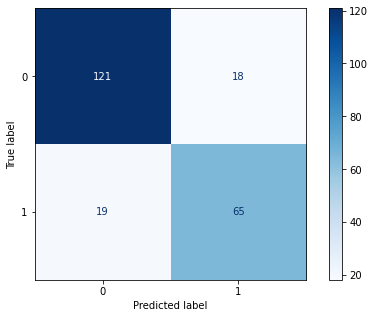

In [82]:
plot_confusion_matrix(nb,X_test,y_test,values_format='d',cmap = 'Blues')
plt.show()

In [83]:
probs = nb.predict_proba(X_test)[:,1]

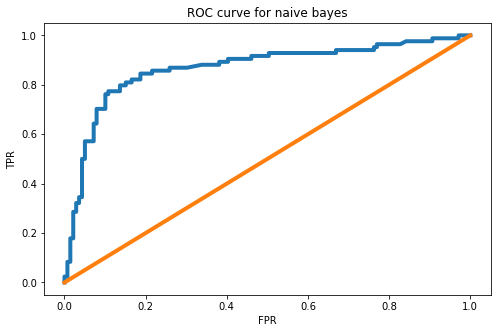

In [84]:
fpr,tpr,thresholds = roc_curve(y_test,probs)

plt.plot(fpr,tpr,linewidth = 4)
plt.plot([0,1],[0,1],linewidth = 4)
plt.title("ROC curve for naive bayes")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [85]:
score = roc_auc_score(y_test,probs)
print("ROC AUC score : {}".format(round(score,4)))

ROC AUC score : 0.8663


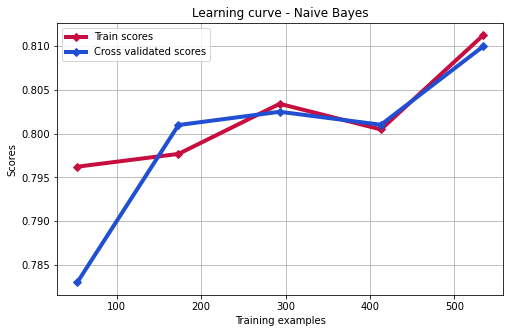

In [86]:
#Learning curve
lc = learning_curve(nb,X_train,y_train)

train_scores_mean = np.mean(lc[1],axis = 1)
test_scores_mean = np.mean(lc[2],axis = 1)

plt.plot(lc[0],train_scores_mean,marker = 'D',linewidth = 4,color = '#C70E41')
plt.plot(lc[0],test_scores_mean,marker = 'D',linewidth = 4,color = '#204FD1')
plt.legend(['Train scores','Cross validated scores'])
plt.title("Learning curve - Naive Bayes")
plt.xlabel("Training examples")
plt.ylabel("Scores")
plt.grid()
plt.show()

# Random Forest Classifier

In [87]:
forest = RandomForestClassifier()

In [88]:
forest.fit(X_train,y_train)

RandomForestClassifier()

In [89]:
scores = cross_validate(forest,X_train,y_train,scoring=['accuracy','f1','roc_auc'])

In [90]:
print("Mean accuracy with cross validation : {:.2f}".format(scores['test_accuracy'].mean()))
print("Mean f1 with cross validation : {:.2f}".format(scores['test_f1'].mean()))
print("Mean ROC AUC score with cross validation : {:.2f}".format(scores['test_roc_auc'].mean()))

Mean accuracy with cross validation : 0.79
Mean f1 with cross validation : 0.73
Mean ROC AUC score with cross validation : 0.85


In [91]:
pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

In [92]:
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(y_train,pred_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(y_test,pred_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(y_test,pred_test))
print("\n=====Classification report=====\n")
print(classification_report(y_test,pred_test))

=====Accuracy score============

Train accuracy score : 0.9656
Test accuracy score : 0.8251

=====Confusion Matrix==========
 
[[120  19]
 [ 20  64]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       139
           1       0.77      0.76      0.77        84

    accuracy                           0.83       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



In [93]:
#Clearly overfits. So we will try to tune the hyperparameters

param_grid = {'n_estimators':[100,200,500,1000],'max_features':[2,3,4,5,6],'max_depth':[2,3,4],'min_samples_leaf':[2,3]}

grid = GridSearchCV(forest,param_grid,refit=True,verbose=2,scoring = "f1_weighted")
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100, total=   0.4s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=100, total=   0.4s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=2, max_features=2, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=2, max_features=2, min_samples

[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=500, total=   0.8s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=500, total=   0.8s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000, total=   1.9s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000, total=   2.3s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000, total=   2.0s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=3, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=2, max_features=3, mi

[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=500, total=   0.9s
[CV] max_depth=2, max_features=4, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=2, max_features=4, min_samples

[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=1000, total=   1.9s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100, total=   0.1s
[CV] max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100, total=   0.1s
[CV] max_depth=2, max_features=6, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_sa

[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500, total=   1.0s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500, total=   0.9s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500, total=   1.0s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500, total=   1.0s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=500, total=   1.0s
[CV] max_depth=3, max_features=2, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=3, max_features=2, min_sample

[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=200, total=   0.3s
[CV] max_depth=3, max_features=3, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=3, max_features=3, min_samples

[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=500, total=   0.8s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=500, total=   0.8s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000, total=   1.8s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000, total=   1.7s
[CV] max_depth=3, max_features=4, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=3, max_features=4, mi

[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=500, total=   0.9s
[CV] max_depth=3, max_features=6, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=3, max_features=6, min_samples

[CV]  max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=1000, total=   2.0s
[CV] max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=1000, total=   2.7s
[CV] max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100, total=   0.3s
[CV] max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100, total=   0.3s
[CV] max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100, total=   0.4s
[CV] max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_sa

[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=200, total=   0.6s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500, total=   1.5s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500, total=   1.5s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500, total=   1.6s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500, total=   1.1s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500 
[CV]  max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=500, total=   1.1s
[CV] max_depth=4, max_features=3, min_samples_leaf=3, n_estimators=1000 
[CV]  max_depth=4, max_features=3, min_sample

[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=100, total=   0.2s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=200, total=   0.4s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=200, total=   0.3s
[CV] max_depth=4, max_features=5, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=4, max_features=5, min_samples

[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=500, total=   0.9s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=500 
[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=500, total=   1.3s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000, total=   2.2s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000, total=   2.2s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000, total=   2.6s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000, total=   3.0s
[CV] max_depth=4, max_features=6, min_samples_leaf=2, n_estimators=1000 
[CV]  max_depth=4, max_features=6, mi

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  8.4min finished


RandomForestClassifier(max_depth=4, max_features=6, min_samples_leaf=3,
                       n_estimators=200)
{'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 3, 'n_estimators': 200}


In [94]:
rf = RandomForestClassifier(max_depth=4,max_features=5,n_estimators=100,min_samples_leaf=3)

In [95]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, max_features=5, min_samples_leaf=3)

In [96]:
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

In [97]:
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(y_train,pred_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(y_test,pred_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(y_test,pred_test))
print("\n=====Classification report=====\n")
print(classification_report(y_test,pred_test))

=====Accuracy score============

Train accuracy score : 0.8368
Test accuracy score : 0.8520

=====Confusion Matrix==========
 
[[128  11]
 [ 22  62]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       139
           1       0.85      0.74      0.79        84

    accuracy                           0.85       223
   macro avg       0.85      0.83      0.84       223
weighted avg       0.85      0.85      0.85       223



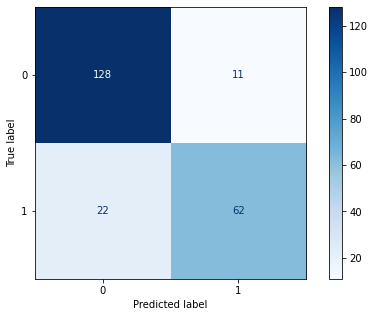

In [98]:
plot_confusion_matrix(rf,X_test,y_test,values_format='d',cmap = 'Blues')
plt.show()

In [99]:
probs = rf.predict_proba(X_test)[:,1]

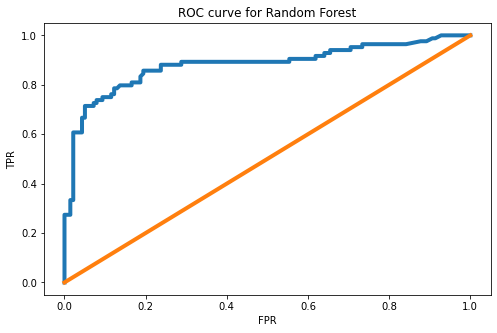

In [100]:
fpr,tpr,thresholds = roc_curve(y_test,probs)

plt.plot(fpr,tpr,linewidth = 4)
plt.plot([0,1],[0,1],linewidth = 4)
plt.title("ROC curve for Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [101]:
score = roc_auc_score(y_test,probs)
print("ROC AUC score : {}".format(round(score,4)))

ROC AUC score : 0.881


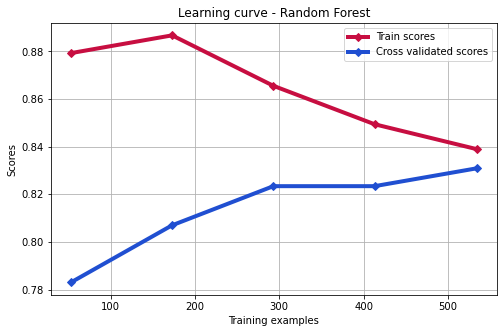

In [102]:
#Learning curve
lc = learning_curve(rf,X_train,y_train)

train_scores_mean = np.mean(lc[1],axis = 1)
test_scores_mean = np.mean(lc[2],axis = 1)

plt.plot(lc[0],train_scores_mean,marker = 'D',linewidth = 4,color = '#C70E41')
plt.plot(lc[0],test_scores_mean,marker = 'D',linewidth = 4,color = '#204FD1')
plt.legend(['Train scores','Cross validated scores'])
plt.title("Learning curve - Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Scores")
plt.grid()
plt.show()

# Pipeline for modeling

In [74]:
passender_id = test_df['PassengerId']

In [75]:
def create_new_features(dataframe):
  dataframe['family_size'] = dataframe['SibSp']+dataframe['Parch']
  dataframe['title'] = dataframe['Name'].apply(lambda x: find_substrings(x,titles_list))
  dataframe['title'] = dataframe.apply(replace_title,axis = 1)

  return dataframe


In [76]:
def preprocessing(dataframe):
  global mean_age_0
  global mean_age_1
  global mean_age_2
  global mean_age_3
  dataframe.drop(columns = ['Name','PassengerId','Ticket','Cabin'],inplace = True)
  dataframe['Sex'] = dataframe['Sex'].map(sex_dict)
  dataframe['Embarked'] = dataframe['Embarked'].map(embark_dict)
  dataframe['title'] = dataframe['title'].map(title_dict)
  dataframe.loc[dataframe['title']==0,'Age'] = dataframe.loc[dataframe['title']==0,'Age'].fillna(mean_age_0)
  dataframe.loc[dataframe['title']==1,'Age'] = dataframe.loc[dataframe['title']==1,'Age'].fillna(mean_age_1)
  dataframe.loc[dataframe['title']==2,'Age'] = dataframe.loc[dataframe['title']==2,'Age'].fillna(mean_age_2)
  dataframe.loc[dataframe['title']==3,'Age'] = dataframe.loc[dataframe['title']==3,'Age'].fillna(mean_age_3)
  

  dataframe['Fare'].fillna(dataframe['Fare'].mean(),inplace = True)

  return dataframe

In [77]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(create_new_features)
t = FunctionTransformer(preprocessing)


In [78]:
transformer.transform(test_df)
t.transform(test_df)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title
0,3,0,34.500000,0,0,7.8292,1,0,0
1,3,1,47.000000,1,0,7.0000,2,1,1
2,2,0,62.000000,0,0,9.6875,1,0,0
3,3,0,27.000000,0,0,8.6625,2,0,0
4,3,1,22.000000,1,1,12.2875,2,2,1
...,...,...,...,...,...,...,...,...,...
413,3,0,32.891990,0,0,8.0500,2,0,0
414,1,1,39.000000,0,0,108.9000,0,0,0
415,3,0,38.500000,0,0,7.2500,2,0,0
416,3,0,32.891990,0,0,8.0500,2,0,0


In [79]:
test_df.isna().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
family_size    0
title          0
dtype: int64

In [80]:
test_df['Survived'] = lr.predict(test_df.values)

In [98]:
with open(f'model.pkl','rb') as f:
    model = pickle.load(f)

In [100]:
Pclass = input()
Sex = input()
Age = input()
SibSp = input()
Parch = input()
Fare = input()
Embarked = input()
family_size = SibSp + Parch
title = input()
input_values = pd.DataFrame([[Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title]],
columns = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','family_size','title'])

sex_dict = {'male':0,'female':1}
input_values['Sex'] = input_values['Sex'].map(sex_dict)
embark_dict = {'C':0,'Q':1,'S':2}
input_values['Embarked'] = input_values['Embarked'].map(embark_dict)
title_dict = {"Mr":0,"Mrs":1,"Miss":2,"Master":3}
input_values['title'] = input_values['title'].map(title_dict)

p = model.predict(input_values.values)

if p[0] == 0:
    prediction = "Not survived"
else:
    prediction = 'Survived'

1
female
22
1
2
20
C
Mrs


0

In [97]:

lr.predict(np.array(m).reshape(1,-1))

array([1])

In [93]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family_size,title,Survived
0,3,0,34.5,0,0,7.8292,1,0,0,0
1,3,1,47.0,1,0,7.0000,2,1,1,0
2,2,0,62.0,0,0,9.6875,1,0,0,0
3,3,0,27.0,0,0,8.6625,2,0,0,0
4,3,1,22.0,1,1,12.2875,2,2,1,0


## Kaggle submission file

In [ ]:
test_df['PassengerId'] = passender_id

In [ ]:
submission = test_df.drop(columns = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','family_size','title'])

In [ ]:
submission = submission[['PassengerId','Survived']]
submission.set_index('PassengerId',drop = True,inplace = True)

## Pickling logistic regression model

In [112]:
with open('model.pkl','wb') as file:
    pickle.dump(lr,file)